# Chapter 8: Gradient Descent

In [1]:
# Chapter 8 from Data Science from Scratch
from collections import Counter
#from linear_algebra import distance, vector_subtract, scalar_multiply
from functools import reduce
import math, random
import sys
import NotebookLoader
sys.meta_path.append(NotebookLoader.NotebookFinder())
import Chapter4 as Ch4

isMain = __name__ == "__main__"

importing Jupyter notebook from Chapter4.ipynb


In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)


def difference_quotient(f, x, h):
    return (f(x+h) - f(x))/h


def square(x):
    return x*x


def derivative(x):
    return 2*x

if isMain:
    derivative_est = lambda x: difference_quotient(square, x, h=.00001)

    import matplotlib.pyplot as plt
    x = range(-10,10)
    plt.title("Actual Derivative vs Esitmates")
    plt.plot(x, [derivative(x_i) for x_i in x], 'rx', label='Actual')
    plt.plot(x, [derivative_est(x_i) for x_i in x], 'b+', label='Estimate')
    plt.legend(loc=9)
    plt.draw()


def partial_difference_quotient(f, v, i, h):
    """compute the ith partial difference quotient of f at v"""
    w = [v_j + (h if j == i else 0) for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h


def estimate_gradient(f, v, h=.00001):
    return [partial_difference_quotient(f, v, i, h) for i, _ in enumerate(v)]


Obviously sum of squares has minimum at $v = \{0\}$ but lets find this using gradient descent

Gradient Descent: Choose random starting point, take steps in the direction of greatest down slope (minimum direction)

In [3]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]


def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

if isMain:
    # pick a random starting point
    v = [random.randint(-10, 10) for _ in range(3)]

    tolerance = .00000001

    while True:
        gradient = sum_of_squares_gradient(v)
        next_v = step(v, gradient, -0.01)
        if Ch4.distance(next_v, v) < tolerance:
            break
        v = next_v
    print("Approx solutions: ", v)

Approx solutions:  [-1.2794544714561508e-07, 2.1324241190935878e-07, -4.2648482381871755e-07]


#### But what should the step size be?

In [4]:
# This is a safe apply function, just in case we try a bad step size
def safe(f):
    """
        Return a new function that is the same as f, except
        that it outputs infinity whenever f produces an error
    """
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f


# Supposing that we have chosen some initial param theta_0, we can implement gradient descent as:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=.0000001):
    """
        Use gradient descent to find the theta that minimizes target function
    """

    step_sizes = [10**(2-i) for i in range(0,8)]

    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(theta)

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]

        # Choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # Stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value


def negate(f):
    """Return a function that for any input x, returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)


def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]


def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=.0000001):
    return minimize_batch(negate(target_fn), negate_all(gradient_fn), theta_0, tolerance)

#### We can use stochastic gradient descent when the error functions are additive. This is better because it saves time on each step. Stochastic gradient descent computes the gradient for only one point at a time

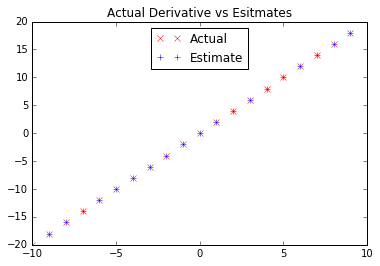

In [5]:
# During each cycle we want to iterate through the data in a random order
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i,_ in enumerate(data)] # create a list of indexes
    random.shuffle(indexes)

    # return the data in this shuffled order
    for i in indexes:
        yield data[i]


# Using the random order, we take a gradient step for each data point
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=.01):

    data = zip(x,y)
    theta = theta_0
    alpha = alpha_0
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # If we ever go to 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're no improving, so we should try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= .9

        # ad take a gradient step for each of the datapoints
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = Ch4.vector_subtract(theta, Ch4.scalar_multiply(alpha, gradient_i))

    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0)

if isMain:
    plt.show()